In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Firstly, we should install required packages

In [5]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio]  evaluate jiwer gradio

In [6]:
!pip install -U bitsandbytes

#### Now we need to log in to Hugging Face and define our training arguments

In [7]:
from huggingface_hub import notebook_login
notebook_login()

# Loading and preparing dataset

#### We will use common voice audio dataset (Version 13.0) to feed into model.

In [5]:
from datasets import load_dataset,DatasetDict
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
dataset_checkpoint='mozilla-foundation/common_voice_13_0'
lang_attr,task='uz','transcribe'
dataset=load_dataset(dataset_checkpoint,lang_attr,split='train+validation')

README.md:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

common_voice_13_0.py:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

languages.py:   0%|          | 0.00/3.65k [00:00<?, ?B/s]

release_stats.py:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

The repository for mozilla-foundation/common_voice_13_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_13_0.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


n_shards.json:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

uz_train_0.tar:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

uz_train_1.tar:   0%|          | 0.00/210M [00:00<?, ?B/s]

uz_dev_0.tar:   0%|          | 0.00/344M [00:00<?, ?B/s]

uz_test_0.tar:   0%|          | 0.00/400M [00:00<?, ?B/s]

uz_other_0.tar:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

uz_other_1.tar:   0%|          | 0.00/886M [00:00<?, ?B/s]

uz_other_2.tar:   0%|          | 0.00/969M [00:00<?, ?B/s]

uz_other_3.tar:   0%|          | 0.00/253M [00:00<?, ?B/s]

uz_invalidated_0.tar:   0%|          | 0.00/397M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

other.tsv:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

invalidated.tsv:   0%|          | 0.00/3.25M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 10141it [00:00, 101393.42it/s]
Reading metadata...: 20281it [00:00, 77760.47it/s] 
Reading metadata...: 28389it [00:00, 74950.90it/s]
Reading metadata...: 36043it [00:00, 68708.80it/s]
Reading metadata...: 48286it [00:00, 72405.53it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 12061it [00:00, 140079.58it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 12321it [00:00, 160209.13it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 16410it [00:00, 164086.86it/s]
Reading metadata...: 32819it [00:00, 163035.66it/s]
Reading metadata...: 49124it [00:00, 148244.25it/s]
Reading metadata...: 64089it [00:00, 144963.61it/s]
Reading metadata...: 78665it [00:00, 142617.87it/s]
Reading metadata...: 92973it [00:00, 136812.22it/s]
Reading metadata...: 106704it [00:00, 134706.63it/s]
Reading metadata...: 127766it [00:00, 137847.07it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 13811it [00:00, 162394.82it/s]


In [7]:
dataset

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 60347
})

#### We just need audio and sentence for STT, so we will remove unnecessary features

In [6]:
dataset=dataset.remove_columns(['client_id', 'path','up_votes', 'down_votes', 'age',
                                'gender', 'accent', 'locale', 'segment', 'variant'],)
dataset

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 60347
})

### Preprocessing

#### Some  preprocessing methods we will apply:
* #### Undersampling (Most of the available pretrained models have been pretrained on audio datasets at a sampling rate of 16 kHz)
* #### Removing special characters (Many special characters encoded differently like: /u2019,/u0020 etc.)

In [7]:
# ‘ ’
from datasets import Audio
dataset=dataset.cast_column('audio',Audio(sampling_rate=16000))

def cleaning_text(samples):
  text_clened=[sentence.strip() \
              .replace('’',"'") \
               .replace('‘',"'")\
               .replace('”','"')\
               .replace('“','"')\
               .replace('»','"')\
               .replace('«','"')\
               .replace('`',"'")\
               
                for sentence in samples['sentence']]
  samples['sentence']=text_clened
  return samples
    
cleaned_dataset=dataset.map(cleaning_text,batched=True)

Map:   0%|          | 0/60347 [00:00<?, ? examples/s]

# Tokenization and Feature Extraction


* #### Whisper Processor-> that combines both the Feature Extractor and Tokenizer.
* #### Whisper Feature Extractor-> Converts raw audio (16kHz waveform) into Mel spectrograms (80 frequency bins).
* #### Whisper Tokenizer-> Converts text into token IDs (for training) and tokens back to text (for transcription output).

In [8]:
from transformers import WhisperFeatureExtractor,WhisperTokenizer,WhisperProcessor
language='uzbek'
task='transcribe'
model_checkpoint='openai/whisper-large-v2'
feature_extractor=WhisperFeatureExtractor.from_pretrained(model_checkpoint)
tokenizer=WhisperTokenizer.from_pretrained(model_checkpoint,language=language,task=task)
processor=WhisperProcessor.from_pretrained(model_checkpoint,language=language,task=task)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [9]:
import os
num_of_device=os.cpu_count()
print(num_of_device)

4


#### Actually We should not use entire dataset, since it takes so many time and device memory for fine-tuning.
#### Let's take just 10.000 dataset raws

In [10]:
dataset=dataset.select(range(10000))
dataset=dataset.train_test_split(test_size=0.1,seed=23)
dataset['validation']=dataset.pop('test')
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 9000
    })
    validation: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 1000
    })
})

#### As mentioned above, we will extract features

In [11]:
def prepare_features(samples):
  audio_array=samples['audio']['array']
  sentence=samples['sentence']
  sampling_rate=samples['audio']['sampling_rate']

  samples['input_features']=feature_extractor(audio_array,sampling_rate=sampling_rate,return_tensors='pt').input_features[0]
  samples['labels']=tokenizer(sentence).input_ids

  return samples

dataset_prep=dataset.map(prepare_features,remove_columns=dataset.column_names['train'],
                         num_proc=1)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

#### Now, we define evaluation metric.
#### WER (Word Error Rate) is mostly used metric to calculate STT accuracy
#### How it work:
<img src="https://sonix.ai/packs/media/images/corp/articles/word-error-rate-2017-c5aba7282b39531154f5676a184c7ec4.png" width="500">
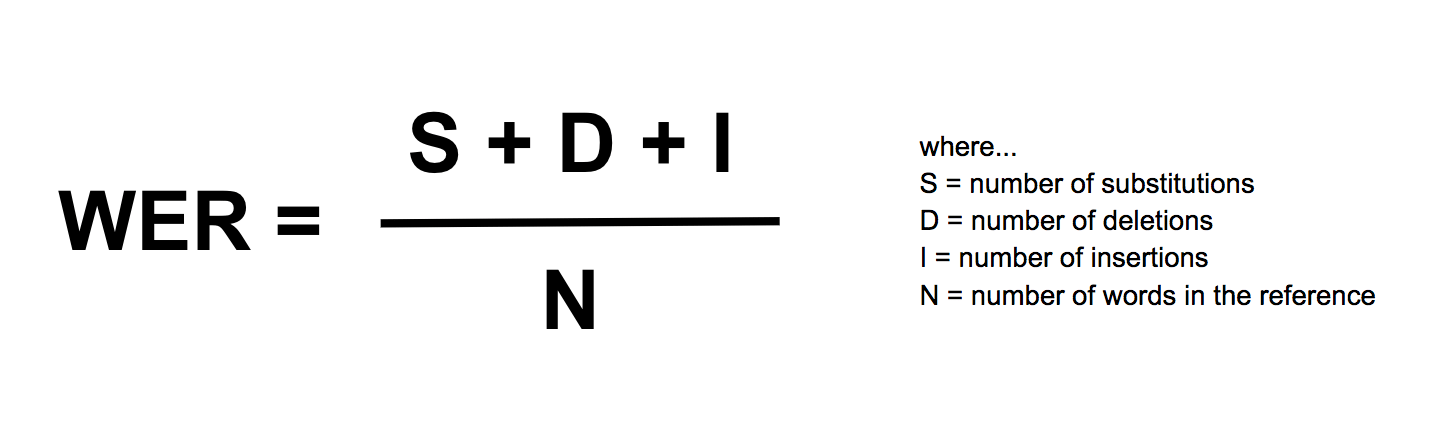

In [12]:
import evaluate
metric=evaluate.load('wer')

#### Also we define data collator function

In [14]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [15]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# Fine-Tuning model

#### Let's briefly talk about Whsiper
**The Whisper model, developed by OpenAI, is a speech-to-text (ASR) model that transcribes audio into text. It is a transformer-based model trained on 680,000 hours of multilingual and multitask data, making it highly robust for diverse accents, background noise, and multiple languages.**

 **According to whisper-large-v2 model, it has around 1.5 bn parameters. It  means that fine-tuning process requires so much time and computational resources. But, we can use PEFT (Parameter Efficent Fine-Tuning) approach for working large models efficently.**
##### **Most used mehod of PEFT is LORA(Low-Rank Adaption:**
<img src="https://miro.medium.com/v2/resize:fit:979/1*-uBCFiiNeOeTLvUtfdA85w.png" width="500">

In [17]:
from transformers import WhisperForConditionalGeneration
model_checkpoint='openai/whisper-large-v2'
model = WhisperForConditionalGeneration.from_pretrained(model_checkpoint,load_in_8bit=True,device_map='auto')

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/4.29k [00:00<?, ?B/s]

#### We configure LORA

In [18]:
from peft import prepare_model_for_kbit_training
from peft import LoraConfig,LoraModel,PeftModel,get_peft_model

model=prepare_model_for_kbit_training(model)

def make_inputs_require_grad(module, input, output):
    output.requires_grad_(True)

model.model.encoder.conv1.register_forward_hook(make_inputs_require_grad)

config=LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=['q_proj','v_proj'],
    lora_dropout=0.05,
    bias='none',
)
model=get_peft_model(model,config)
model.print_trainable_parameters()

trainable params: 15,728,640 || all params: 1,559,033,600 || trainable%: 1.0089


#### We are ONLY using 1% of the total trainable parameters, thereby performing Parameter-Efficient Fine-Tuning

#### Then we define training arguments argument

In [20]:
from transformers import Seq2SeqTrainingArguments


training_args = Seq2SeqTrainingArguments(
    output_dir="ShakhzoDavronov/whisper-large-lora-uz",
    report_to='none',
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=1,
    evaluation_strategy="steps",
    fp16=True,
    per_device_eval_batch_size=4,
    generation_max_length=128,
    logging_steps=300,
#    max_steps=100, # only for testing purposes, remove this from your final run :)
    remove_unused_columns=False,  # required as the PeftModel forward doesn't have the signature of the wrapped model's forward
    label_names=["labels"],  # same reason as above
)
import torch
torch.cuda.empty_cache()  

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
from transformers import Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR

# This callback helps to save only the adapter weights and remove the base model weights.
class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control


trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_prep["train"],
    eval_dataset=dataset_prep["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)
model.config.use_cache=False

<ipython-input-21-f6bbe916fd7d>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [22]:
import torch
torch.cuda.empty_cache()

#### Finally, we will begin fine-tuning process

In [23]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
300,1.191500,0.819220
600,0.752200,0.639745
900,0.624600,0.550214


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reen

TrainOutput(global_step=1125, training_loss=0.7942371622721354, metrics={'train_runtime': 17117.3409, 'train_samples_per_second': 0.526, 'train_steps_per_second': 0.066, 'total_flos': 1.93123823616e+19, 'train_loss': 0.7942371622721354, 'epoch': 1.0})

#### Pushing fine-tuned model to huggingface

In [24]:
peft_model_id = "ShakhzoDavronov/whisper-large-lora-uz"
model.push_to_hub(peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ShakhzoDavronov/whisper-large-lora-uz/commit/7d3175bf3950e837d032cc9dee1991fd47db954f', commit_message='Upload model', commit_description='', oid='7d3175bf3950e837d032cc9dee1991fd47db954f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ShakhzoDavronov/whisper-large-lora-uz', endpoint='https://huggingface.co', repo_type='model', repo_id='ShakhzoDavronov/whisper-large-lora-uz'), pr_revision=None, pr_num=None)

In [25]:
from huggingface_hub import notebook_login
notebook_login()

In [26]:
from peft import PeftModel, PeftConfig
from transformers import WhisperForConditionalGeneration, Seq2SeqTrainer

#peft_model_id = "ShakhzoDavronov/whisper-stt-lora-uz" # Use the same model ID as before.
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)
model = PeftModel.from_pretrained(model, peft_model_id)
model.config.use_cache = True

adapter_config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


adapter_model.safetensors:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

#### Let's calculate WER with validation data

In [27]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(dataset_prep["validation"], batch_size=8, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []

model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute(predictions=predictions, references=references)
normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/wer": wer, "eval/normalized_wer": normalized_wer}

print(f"{wer=} and {normalized_wer=}")
print(eval_metrics)

  0%|          | 0/125 [00:00<?, ?it/s]<ipython-input-27-6a2c04a2b42d>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 125/125 [39:53<00:00, 19.15s/it]


wer=47.418948693736226 and normalized_wer=33.14993122420908
{'eval/wer': 47.418948693736226, 'eval/normalized_wer': 33.14993122420908}


#### There is two evalutaion values: WER and normalized WER
#### Normalized WER is a variant of WER that applies text normalization before computing the error rate.